In [60]:
# Set up libraries and backend
from qiskit.tools.jupyter import * 
from qiskit import IBMQ
from qiskit import assemble
import numpy as np
import matplotlib.pyplot as plt
from qiskit import pulse
from qiskit import pulse
from qiskit.pulse import Play
from qiskit.tools.monitor import job_monitor
from scipy.optimize import curve_fit
import json

%config InlineBackend.figure_format = 'svg'
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support OpenPulse"

# Use for conversions later
GHz = 1.0e9
MHz = 1.0e6
kHz = 1.0e3
ms = 1.0e-3
us = 1.0e-6
ns = 1.0e-9
scale_factor = 1e-14

# Initialize qubit to |0> and retrieve backend frequencies
qubit = 0
dt = backend_config.dt
backend_defaults = backend.defaults()
qubit_props_dict = backend.properties().qubit_property(0)
rough_qubit_freq = qubit_props_dict['frequency'][0]
rough_cav_freq = backend_defaults.meas_freq_est[qubit]


# Define and configure measurement map (hardware constraint)
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in meas_map!"
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)
qubit_meas_group = backend_config.meas_map[meas_map_idx]
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=qubit_meas_group)


# Define for convenience
def get_closest_multiple_of_16(num):
     return int(num + 8) - (int(num + 8) % 16)

# Functions to save data to and load data from external text files
def saveData(dataset, file):
    filehandler = open(file, 'w')
    json.dump(dataset, filehandler)
    filehandler.close()
    
def loadData(file):
    filehandler = open(file)
    data = json.load(filehandler)
    filehandler.close()
    return data

def get_job_data(job):
    result = job.result(timeout=120)
    sweep = []
    for i in range(len(result.results)):
        res = result.get_memory(i)*scale_factor
        sweep.append(res[qubit])
    return sweep

# Define curve fitting function
def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params, maxfev=5000)
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit

/opt/anaconda3/envs/newerQiskit/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2021-01-14 01:41:52,835: Credentials are already in use. The existing account in the session will be replaced.


In [61]:
# here we are trying to find  T1 as function of cavity drive pulse strength (vary amplitude)
min_amp_v1_1 = 0.0 
max_amp_v1_1 = 0.4
min_amp_v1_2 = 0.5
max_amp_v1_2 = 0.9
num_amps = 5
amps_v1_1 = np.linspace(min_amp_v1_1, max_amp_v1_1, num_amps, endpoint=True) # first half of amplitudes
amps_v1_2 = np.linspace(min_amp_v1_2, max_amp_v1_2, num_amps, endpoint=True) # second half

acq_time_us_v1 = 0.5 # small acquisition time gives more reliable results
num_trials_v1 = 3 # avg T1 decay curves over several trials due to noise

min_time_us_v1 = 5 # times over which T1 decay is measuredd
max_time_us_v1 = 300 
num_times_v1 = 75
times_us_v1 = np.linspace(min_time_us_v1, max_time_us_v1, num_times_v1, endpoint=True) # times array

In [62]:
# data taken from past experiments. First subarray is gnd state experiments (cav drive for specific duration + measure),
# second subarray is exc state experiments (pi pulse + cav drive for specific duration + measure). Acq pulse and pi 
# pulse fixed for all experiments, drive times in each experiment given by times_us_v1. For gnd/exc states, cav drive 
# was performed with one of 10 specific amplitudes (0.0 - 0.9 au) and 3 trials were performed for each amplitude and 
# averaged over to get a more reliable picture. 
all_job_IDs = [ [
                [['5fedd0cb9b56240019a79bed', '5fedd0dd298e7d001960c593', '5fedd0e9ddf3cb001a25d55b', '5fedd0f59b56240019a79bf0', '5fedd10154c618001956f3e4'],
                ['5fedddfbddf3cb001a25d618', '5fedde029b56240019a79c88', '5fedde119c8671001a2ae62d', '5fedde1c5c8bdb001a5e0653', '5fedde2619f73a001a2253f1'],
                ['5feded2c9c8671001a2ae6ca', '5feded378d763c001aa5a405', '5feded479c8671001a2ae6cc', '5feded539c8671001a2ae6ce', '5feded5e9c8671001a2ae6d0']],
                [['5fee44be9c8671001a2aea9b', '5fee44d0298e7d001960caa4', '5fee44e9ddf3cb001a25da41', '5fee44f419f73a001a22581c', '5fee450219f73a001a22581e'],
                ['5fee52ee9c8671001a2aeb5c', '5fee52ff9c8671001a2aeb5d', '5fee530d5c8bdb001a5e0b35', '5fee5319ddf3cb001a25db1a', '5fee53264a2598001ac5b308'],
                ['5fee61959c8671001a2aec0c', '5fee61a64a2598001ac5b3af', '5fee61b54a2598001ac5b3b1', '5fee61c1ddf3cb001a25dbc2', '5fee61cc4a2598001ac5b3b3']]
                ],
                [
                [['5fee7e6b19f73a001a225b19', '5fee7e78ddf3cb001a25dd74', '5fee7e86298e7d001960cda7', '5fee7e964a2598001ac5b53b', '5fee7ea5ddf3cb001a25dd76'],
                ['5fee8b0c9c8671001a2aee33', '5fee8b1a4a2598001ac5b5c2', '5fee8b2800eede001aebc20e', '5fee8b344a2598001ac5b5c3', '5fee8b3e00eede001aebc210'],
                ['5fee99e8298e7d001960cec2', '5fee99f654c618001956fcd4', '5fee9a018d763c001aa5ac07', '5fee9a0c298e7d001960cec4', '5fee9a159c8671001a2aeedb']],
                [['5feeb4499b56240019a7a5df', '5feeb45f00eede001aebc3f4', '5feeb46b9c8671001a2af00c', '5feeb4768d763c001aa5ad42', '5feeb4824a2598001ac5b795'],
                ['5feeb6258d763c001aa5ad55', '5feeb6365c8bdb001a5e0fde', '5feeb6419b56240019a7a5fb', '5feeb64c8d763c001aa5ad5b', '5feeb6579b56240019a7a5fc'],
                ['5feeb7f84a2598001ac5b7b3', '5feeb8064a2598001ac5b7b4', '5feeb8104a2598001ac5b7b6', '5feeb81a298e7d001960d00d', '5feeb826ddf3cb001a25dfe7']]
                ]
             ]

# divide into 3 groups of jobs since there were 3 trials for every setup
gs_job_IDs = all_job_IDs[0] # all gnd state jobs
es_job_IDs = all_job_IDs[1] # all exc state jobs
gs_job_IDs_1 = gs_job_IDs[0] # set of all trials for gnd state jobs where drive amp = 0.0 - 0.4
gs_job_IDs_2 = gs_job_IDs[1] # set of all trials for gnd state jobs where drive amp = 0.5 - 0.9
es_job_IDs_1 = es_job_IDs[0] # set of all trials for exc state jobs where drive amp = 0.0 - 0.4
es_job_IDs_2 = es_job_IDs[1] # set of all trials for exc state jobs where drive amp = 0.5 - 0.9


In [63]:
# organizes data into trials of amp-specific experiements
tot_gs_data_v1_1 = [] # data for all trials of gnd state experiements with amp = 0.0-0.4
for i in range(num_trials_v1):
    trial_spec = []
    for j in range(num_amps):
        this_job = backend.retrieve_job(gs_job_IDs_1[i][j])
        this_data = get_job_data(this_job)
        trial_spec.append(this_data)
    tot_gs_data_v1_1.append(trial_spec)
    
tot_gs_data_v1_2 = [] # data for all trials of gnd state experiements with amp = 0.5-0.9
for i in range(num_trials_v1):
    trial_spec = []
    for j in range(num_amps):
        this_job = backend.retrieve_job(gs_job_IDs_2[i][j])
        this_data = get_job_data(this_job)
        trial_spec.append(this_data)
    tot_gs_data_v1_2.append(trial_spec)
    
tot_es_data_v1_1 = [] # data for all trials of exc state experiements with amp = 0.0-0.4
for i in range(num_trials_v1):
    trial_spec = []
    for j in range(num_amps):
        this_job = backend.retrieve_job(es_job_IDs_1[i][j])
        this_data = get_job_data(this_job)
        trial_spec.append(this_data)
    tot_es_data_v1_1.append(trial_spec)
    
tot_es_data_v1_2 = [] # data for all trials of exc state experiements with amp = 0.5-0.9
for i in range(num_trials_v1):
    trial_spec = []
    for j in range(num_amps):
        this_job = backend.retrieve_job(es_job_IDs_2[i][j])
        this_data = get_job_data(this_job)
        trial_spec.append(this_data)
    tot_es_data_v1_2.append(trial_spec)

In [64]:
# take trial-average over data by magnitude and phase values, NOT by real and imag values. Repeat for every group
tot_gs_data_v1_1[1][4] = (np.array(tot_gs_data_v1_1[0][4]) + np.array(tot_gs_data_v1_1[2][4])) / 2 

avg_gs_data_v1_1= [] # gnd state data where amp=0.0-0.4, avged over all 3 trials
for i in range(num_amps):
    avg_mag = np.array([0+0j] * len(times_us_v1))
    avg_phase = np.array([0+0j] * len(times_us_v1))
    for j in range(num_trials_v1):
        data = tot_gs_data_v1_1[j][i]
        mag = np.abs(data)
        phase = np.angle(data)
        if (i == 1):
            phase = np.negative(phase)
        avg_mag += np.array(mag)
        avg_phase += np.array(phase)
    avg_mag = avg_mag / num_trials_v1
    avg_phase = avg_phase / num_trials_v1
    
    real = np.array([avg_mag[i] * np.cos(avg_phase[i]) for i in range(len(avg_mag))])
    imag = np.array([avg_mag[i] * np.sin(avg_phase[i]) for i in range(len(avg_mag))])
    comp = (real + 1j * imag).tolist()
    avg_gs_data_v1_1.append(comp)

In [65]:
avg_gs_data_v1_2 = [] # gnd state data where amp=0.5-0.9, avged over all 3 trials
for i in range(num_amps):
    avg_mag = np.array([0+0j] * len(times_us_v1))
    avg_phase = np.array([0+0j] * len(times_us_v1))
    for j in range(num_trials_v1):
        data = tot_gs_data_v1_2[j][i]
        mag = np.abs(data)
        phase = np.angle(data)
        avg_mag += np.array(mag)
        avg_phase += np.array(phase)
    avg_mag = avg_mag / num_trials_v1
    avg_phase = avg_phase / num_trials_v1
    
    real = np.array([avg_mag[i] * np.cos(avg_phase[i]) for i in range(len(avg_mag))])
    imag = np.array([avg_mag[i] * np.sin(avg_phase[i]) for i in range(len(avg_mag))])
    comp = (real + 1j * imag).tolist()
    avg_gs_data_v1_2.append(comp)

In [66]:
avg_es_data_v1_1 = [] # exc state data where amp=0.0-0.4, avged over all 3 trials
for i in range(num_amps):
    avg_mag = np.array([0+0j] * len(times_us_v1))
    avg_phase = np.array([0+0j] * len(times_us_v1))
    for j in range(num_trials_v1):
        data = tot_es_data_v1_1[j][i]
        mag = np.abs(data)
        phase = np.angle(data)
        avg_mag += np.array(mag)
        avg_phase += np.array(phase)
    avg_mag = avg_mag / num_trials_v1
    avg_phase = avg_phase / num_trials_v1
    
    real = np.array([avg_mag[i] * np.cos(avg_phase[i]) for i in range(len(avg_mag))])
    imag = np.array([avg_mag[i] * np.sin(avg_phase[i]) for i in range(len(avg_mag))])
    comp = (real + 1j * imag).tolist()
    avg_es_data_v1_1.append(comp)

In [67]:
avg_es_data_v1_2 = [] # exc state data where amp=0.5-0.9, avged over all 3 trials
for i in range(num_amps):
    avg_mag = np.array([0+0j] * len(times_us_v1))
    avg_phase = np.array([0+0j] * len(times_us_v1))
    for j in range(num_trials_v1):
        data = tot_es_data_v1_2[j][i]
        mag = np.abs(data)
        phase = np.angle(data)
        avg_mag += np.array(mag)
        avg_phase += np.array(phase)
    avg_mag = avg_mag / num_trials_v1
    avg_phase = avg_phase / num_trials_v1
    
    real = np.array([avg_mag[i] * np.cos(avg_phase[i]) for i in range(len(avg_mag))])
    imag = np.array([avg_mag[i] * np.sin(avg_phase[i]) for i in range(len(avg_mag))])
    comp = (real + 1j * imag).tolist()
    avg_es_data_v1_2.append(comp)

In [68]:
# Concatenate results to have 1 gnd state 1 exc state array of amp-specific data
avg_gs_data_v1 = np.concatenate([avg_gs_data_v1_1, avg_gs_data_v1_2]) # avged gnd data for amp = 0.0-0.9 (all amps)
avg_es_data_v1 = np.concatenate([avg_es_data_v1_1, avg_es_data_v1_2]) # avged exc data for amp = 0.0-0.9 (all amps)
amps_v1 = np.concatenate([amps_v1_1, amps_v1_2]) # all amps 0.0-0.9

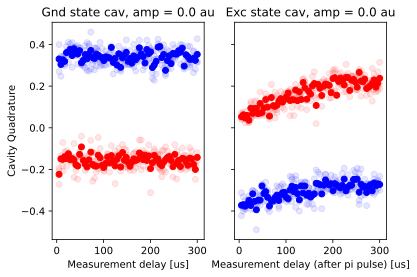

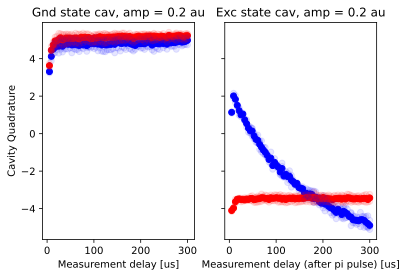

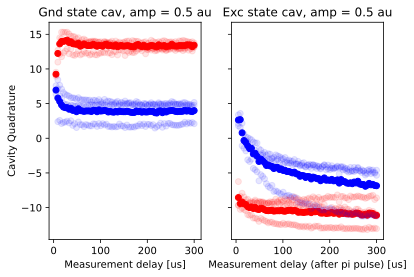

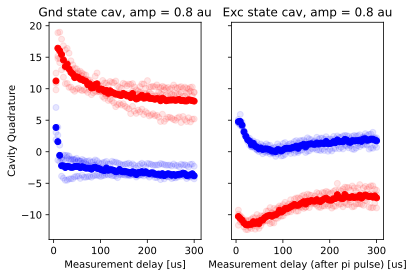

In [69]:
# Plot real and imaginary components of averaged ground and excited state data. Selected amps = 0.0, 0.2, 0.5, 0.8
valid_i = [0, 2, 5, 8]
trans = 0.1

for i in range(len(avg_gs_data_v1)):
    if (i in valid_i):
        fig, ax = plt.subplots(1, 2, sharey='row')
        ax[0].scatter(times_us_v1, np.real(avg_gs_data_v1[i]), color='blue')
        ax[0].scatter(times_us_v1, np.imag(avg_gs_data_v1[i]), color='red')
        if (i < 5):
            for j in range(num_trials_v1):
                ax[0].scatter(times_us_v1, np.real(tot_gs_data_v1_1[j][i]), color='blue', alpha=trans)
                ax[0].scatter(times_us_v1, np.imag(tot_gs_data_v1_1[j][i]), color='red', alpha=trans)
        else:
            for j in range(num_trials_v1):
                ax[0].scatter(times_us_v1, np.real(tot_gs_data_v1_2[j][i - 5]), color='blue', alpha=trans)
                ax[0].scatter(times_us_v1, np.imag(tot_gs_data_v1_2[j][i - 5]), color='red', alpha=trans)
        ax[0].set_xlabel("Measurement delay [us]")
        ax[0].set_ylabel("Cavity Quadrature")
        ax[0].set_title(f"Gnd state cav, amp = {amps_v1[i]} au")
    
        ax[1].scatter(times_us_v1, np.real(avg_es_data_v1[i]), color='blue')
        ax[1].scatter(times_us_v1, np.imag(avg_es_data_v1[i]), color='red')
        if (i < 5):
            for j in range(num_trials_v1):
                ax[1].scatter(times_us_v1, np.real(tot_es_data_v1_1[j][i]), color='blue', alpha=trans)
                ax[1].scatter(times_us_v1, np.imag(tot_es_data_v1_1[j][i]), color='red', alpha=trans)
        else:
            for j in range(num_trials_v1):
                ax[1].scatter(times_us_v1, np.real(tot_es_data_v1_2[j][i - 5]), color='blue', alpha=trans)
                ax[1].scatter(times_us_v1, np.imag(tot_es_data_v1_2[j][i - 5]), color='red', alpha=trans)
        ax[1].set_xlabel("Measurement delay (after pi pulse) [us]")
        ax[1].set_title(f"Exc state cav, amp = {amps_v1[i]} au")

        plt.show()

In [70]:
# Create real and imaginary vectors of gs/es data by amplitude
X_0 = np.real(avg_gs_data_v1[0])
X_2 = np.real(avg_gs_data_v1[2])
X_5 = np.real(avg_gs_data_v1[5])
X_8 = np.real(avg_gs_data_v1[8])

Y_0 = np.imag(avg_gs_data_v1[0])
Y_2 = np.imag(avg_gs_data_v1[2])
Y_5 = np.imag(avg_gs_data_v1[5])
Y_8 = np.imag(avg_gs_data_v1[8])

Z_0 = np.real(avg_es_data_v1[0])
Z_2 = np.real(avg_es_data_v1[2])
Z_5 = np.real(avg_es_data_v1[5])
Z_8 = np.real(avg_es_data_v1[8])

W_0 = np.imag(avg_es_data_v1[0])
W_2 = np.imag(avg_es_data_v1[2])
W_5 = np.imag(avg_es_data_v1[5])
W_8 = np.imag(avg_es_data_v1[8])

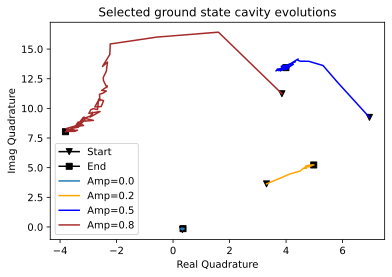

In [71]:
# Plot all gs data together and assign diff colors to diff amplitudes. Mark starting pt with v and ending pt with ^
plt.plot(X_0[0], Y_0[0], marker='v', color='black', label="Start")
plt.plot(X_0[-1], Y_0[-1], marker='s', color='black', label="End")
plt.plot(X_0, Y_0, label=f"Amp={amps_v1[0]}")

plt.plot(X_2[0], Y_2[0], marker='v', color='black')
plt.plot(X_2[-1], Y_2[-1], marker='s', color='black')
plt.plot(X_2, Y_2, color='orange', label=f"Amp={amps_v1[2]}")

plt.plot(X_5[0], Y_5[0], marker='v', color='black')
plt.plot(X_5[-1], Y_5[-1], marker='s', color='black')
plt.plot(X_5, Y_5, color='blue', label=f"Amp={amps_v1[5]}")

plt.plot(X_8[0], Y_8[0], marker='v', color='black')
plt.plot(X_8[-1], Y_8[-1], marker='s', color='black')
plt.plot(X_8, Y_8, color='brown', label=f"Amp={amps_v1[8]}")

plt.xlabel("Real Quadrature")
plt.ylabel("Imag Quadrature")
plt.title("Selected ground state cavity evolutions")
plt.legend()
plt.show()

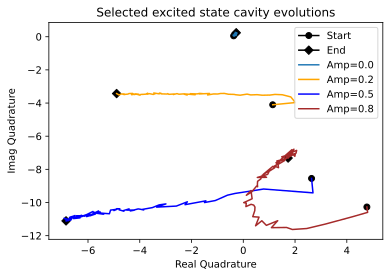

In [72]:
# Plot all es data together and assign diff colors to diff amplitudes. Mark starting pt with v and ending pt with ^
plt.plot(Z_0[0], W_0[0], marker='o', color='black', label="Start")
plt.plot(Z_0[-1], W_0[-1], marker='D', color='black', label="End")
plt.plot(Z_0, W_0, label=f"Amp={amps_v1[0]}")

plt.plot(Z_2[0], W_2[0], marker='o', color='black')
plt.plot(Z_2[-1], W_2[-1], marker='D', color='black')
plt.plot(Z_2, W_2, color='orange', label=f"Amp={amps_v1[2]}")

plt.plot(Z_5[0], W_5[0], marker='o', color='black')
plt.plot(Z_5[-1], W_5[-1], marker='D', color='black')
plt.plot(Z_5, W_5, color='blue', label=f"Amp={amps_v1[5]}")

plt.plot(Z_8[0], W_8[0], marker='o', color='black')
plt.plot(Z_8[-1], W_8[-1], marker='D', color='black')
plt.plot(Z_8, W_8, color='brown', label=f"Amp={amps_v1[8]}")

plt.xlabel("Real Quadrature")
plt.ylabel("Imag Quadrature")
plt.title("Selected excited state cavity evolutions")
plt.legend()
plt.show()

In [73]:
# adjust excited state data so that its final phase matches with that of ground state data
mod_avg_es_data_v1 = []
for i in range(len(avg_gs_data_v1)):
    target = np.angle(avg_gs_data_v1[i][-1])
    start = np.angle(avg_es_data_v1[i][-1])
    shift = target - start
    shifted_phase = np.array(np.angle(avg_es_data_v1[i])) + shift
    mag = np.abs(avg_es_data_v1[i])
    
    real = np.array([mag[i] * np.cos(shifted_phase[i]) for i in range(len(mag))])
    imag = np.array([mag[i] * np.sin(shifted_phase[i]) for i in range(len(mag))])
    comp = (real + 1j * imag).tolist()
    mod_avg_es_data_v1.append(comp)

In [74]:
A_0 = np.real(mod_avg_es_data_v1[0])
A_2 = np.real(mod_avg_es_data_v1[2])
A_5 = np.real(mod_avg_es_data_v1[5])
A_8 = np.real(mod_avg_es_data_v1[8])

B_0 = np.imag(mod_avg_es_data_v1[0])
B_2 = np.imag(mod_avg_es_data_v1[2])
B_5 = np.imag(mod_avg_es_data_v1[5])
B_8 = np.imag(mod_avg_es_data_v1[8])

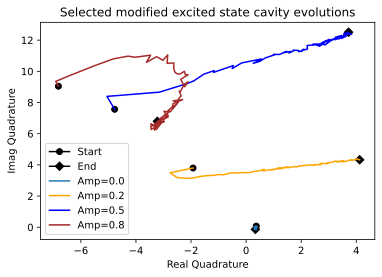

In [75]:
# Plot all mod es data together and assign diff colors to diff amplitudes. Mark starting pt with v and ending pt with ^
plt.plot(A_0[0], B_0[0], marker='o', color='black', label="Start")
plt.plot(A_0[-1], B_0[-1], marker='D', color='black', label="End")
plt.plot(A_0, B_0, label=f"Amp={amps_v1[0]}")

plt.plot(A_2[0], B_2[0], marker='o', color='black')
plt.plot(A_2[-1], B_2[-1], marker='D', color='black')
plt.plot(A_2, B_2, color='orange', label=f"Amp={amps_v1[2]}")

plt.plot(A_5[0], B_5[0], marker='o', color='black')
plt.plot(A_5[-1], B_5[-1], marker='D', color='black')
plt.plot(A_5, B_5, color='blue', label=f"Amp={amps_v1[5]}")

plt.plot(A_8[0], B_8[0], marker='o', color='black')
plt.plot(A_8[-1], B_8[-1], marker='D', color='black')
plt.plot(A_8, B_8, color='brown', label=f"Amp={amps_v1[8]}")

plt.xlabel("Real Quadrature")
plt.ylabel("Imag Quadrature")
plt.title("Selected modified excited state cavity evolutions")
plt.legend()
plt.show()

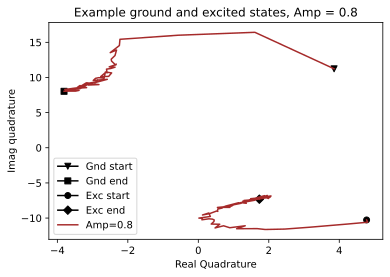

In [76]:
# Plot amp=0.8 ground and excited state data
plt.plot(X_8[0], Y_8[0], marker='v', color='black', label="Gnd start")
plt.plot(X_8[-1], Y_8[-1], marker='s', color='black', label="Gnd end")
plt.plot(X_8, Y_8, color='brown')

plt.plot(Z_8[0], W_8[0], marker='o', color='black', label="Exc start")
plt.plot(Z_8[-1], W_8[-1], marker='D', color='black', label="Exc end")
plt.plot(Z_8, W_8, color='brown', label=f"Amp={amps_v1[8]}")

plt.xlabel("Real Quadrature")
plt.ylabel("Imag quadrature")
plt.title(f"Example ground and excited states, Amp = 0.8")

plt.legend()
plt.show()

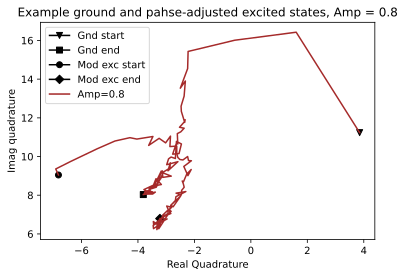

In [77]:
# Plot amp=0.8 ground and phase-adjusted excited state data
plt.plot(X_8[0], Y_8[0], marker='v', color='black', label="Gnd start")
plt.plot(X_8[-1], Y_8[-1], marker='s', color='black', label="Gnd end")
plt.plot(X_8, Y_8, color='brown')

plt.plot(A_8[0], B_8[0], marker='o', color='black', label="Mod exc start")
plt.plot(A_8[-1], B_8[-1], marker='D', color='black', label="Mod exc end")
plt.plot(A_8, B_8, color='brown', label=f"Amp={amps_v1[8]}")

plt.xlabel("Real Quadrature")
plt.ylabel("Imag quadrature")
plt.title(f"Example ground and phase-adjusted excited states, Amp = 0.8")

plt.legend()
plt.show()

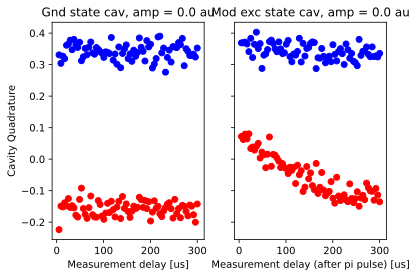

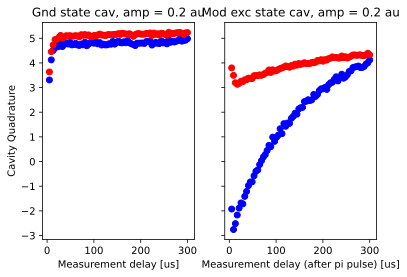

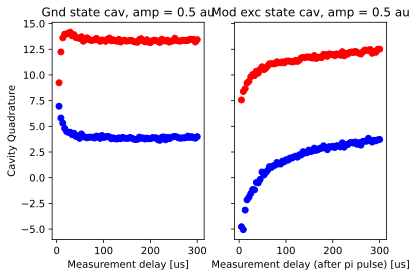

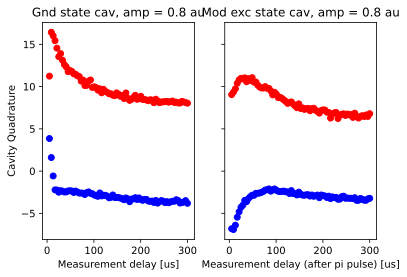

In [78]:
# Plot real and imaginary components of averaged ground and mod excited state data. Selected amps = 0.0, 0.2, 0.5, 0.8
valid_i = [0, 2, 5, 8]

for i in range(len(avg_gs_data_v1)):
    if (i in valid_i):
        fig, ax = plt.subplots(1, 2, sharey='row')
        ax[0].scatter(times_us_v1, np.real(avg_gs_data_v1[i]), color='blue')
        ax[0].scatter(times_us_v1, np.imag(avg_gs_data_v1[i]), color='red')
        ax[0].set_xlabel("Measurement delay [us]")
        ax[0].set_ylabel("Cavity Quadrature")
        ax[0].set_title(f"Gnd state cav, amp = {amps_v1[i]} au")
    
        ax[1].scatter(times_us_v1, np.real(mod_avg_es_data_v1[i]), color='blue')
        ax[1].scatter(times_us_v1, np.imag(mod_avg_es_data_v1[i]), color='red')
        ax[1].set_xlabel("Measurement delay (after pi pulse) [us]")
        ax[1].set_title(f"Mod exc state cav, amp = {amps_v1[i]} au")

        plt.show()

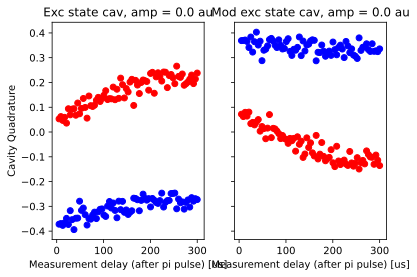

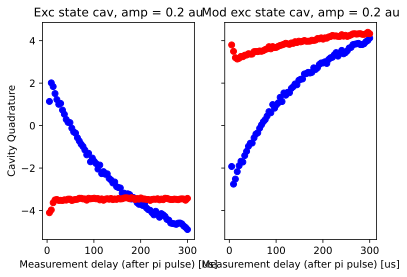

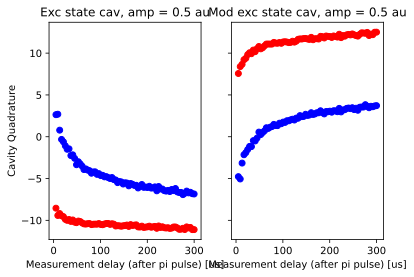

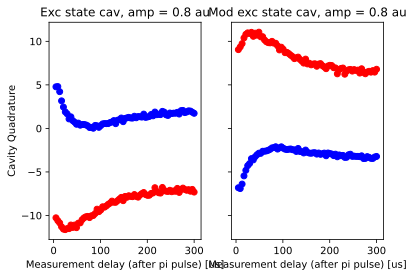

In [79]:
# Plot real and imaginary components of averaged excited and mod excited state data. Selected amps = 0.0, 0.2, 0.5, 0.8
valid_i = [0, 2, 5, 8]

for i in range(len(avg_es_data_v1)):
    if (i in valid_i):
        fig, ax = plt.subplots(1, 2, sharey='row')
        ax[0].scatter(times_us_v1, np.real(avg_es_data_v1[i]), color='blue')
        ax[0].scatter(times_us_v1, np.imag(avg_es_data_v1[i]), color='red')
        ax[0].set_xlabel("Measurement delay (after pi pulse) [us]")
        ax[0].set_ylabel("Cavity Quadrature")
        ax[0].set_title(f"Exc state cav, amp = {amps_v1[i]} au")
    
        ax[1].scatter(times_us_v1, np.real(mod_avg_es_data_v1[i]), color='blue')
        ax[1].scatter(times_us_v1, np.imag(mod_avg_es_data_v1[i]), color='red')
        ax[1].set_xlabel("Measurement delay (after pi pulse) [us]")
        ax[1].set_title(f"Mod exc state cav, amp = {amps_v1[i]} au")

        plt.show()

In [129]:
# Fit real and imaginary components of excited and phase-corrected excited T1 data
exc_T1s = []
mod_exc_T1s = []
real_plots = []
imag_plots = []
mod_real_plots = []
mod_imag_plots = []
settle = 15

for i in range(len(avg_es_data_v1)):
    es_sweep = avg_es_data_v1[i]
    ref_pt = es_sweep[settle]
    real_params, real_fit = fit_function(times_us_v1, np.real(es_sweep), 
                                         lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
                                         [int(np.real(ref_pt)), 0, 100])
    imag_params, imag_fit = fit_function(times_us_v1, np.imag(es_sweep), 
                                         lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
                                         [int(np.imag(ref_pt)), 0, 100])
    
    mod_es_sweep = mod_avg_es_data_v1[i]
    mod_ref_pt = mod_es_sweep[settle]
    mod_real_params, mod_real_fit = fit_function(times_us_v1, np.real(mod_es_sweep), 
                                       lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
                                        [int(np.real(mod_ref_pt)), 0, 100])
    mod_imag_params, mod_imag_fit = fit_function(times_us_v1, np.imag(mod_es_sweep), 
                                        lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
                                        [int(np.imag(mod_ref_pt)), 0, 100])
    
    _, _, real_t1 = real_params
    _, _, imag_t1 = imag_params
    _, _, mod_real_t1 = mod_real_params
    _, _, mod_imag_t1 = mod_imag_params
    
    t1 = real_t1 + 1j * imag_t1
    mod_t1 = mod_real_t1 + 1j * mod_imag_t1
    
    exc_T1s.append(t1)
    mod_exc_T1s.append(mod_t1)
    real_plots.append(real_fit)
    imag_plots.append(imag_fit)
    mod_real_plots.append(mod_real_fit)
    mod_imag_plots.append(mod_imag_fit)

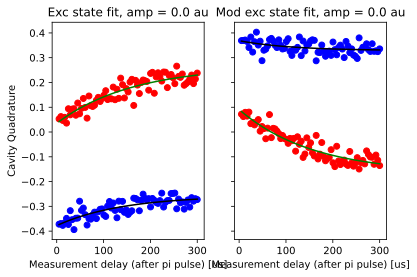

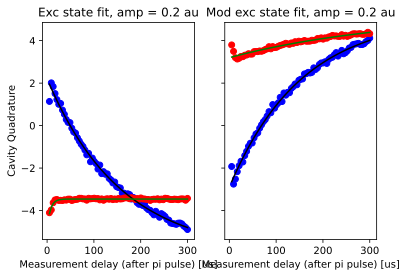

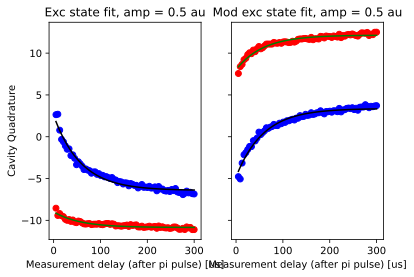

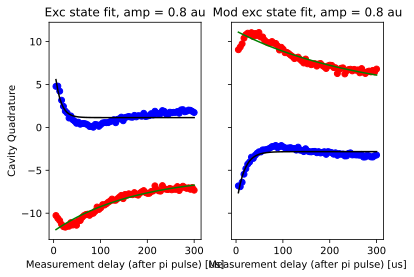

In [151]:
# Plot real and imaginary fits of averaged excited and mod excited state data. Selected amps = 0.0, 0.2, 0.5, 0.8
valid_i = [0, 2, 5, 8]

for i in range(len(avg_es_data_v1)):
    if (i in valid_i):
        fig, ax = plt.subplots(1, 2, sharey='row')
        ax[0].scatter(times_us_v1, np.real(avg_es_data_v1[i]), color='blue')
        ax[0].scatter(times_us_v1, np.imag(avg_es_data_v1[i]), color='red')
        ax[0].plot(times_us_v1, real_plots[i], color='black')
        ax[0].plot(times_us_v1, imag_plots[i], color='green')
        ax[0].set_xlabel("Measurement delay (after pi pulse) [us]")
        ax[0].set_ylabel("Cavity Quadrature")
        ax[0].set_title(f"Exc state fit, amp = {amps_v1[i]} au")
    
        ax[1].scatter(times_us_v1, np.real(mod_avg_es_data_v1[i]), color='blue')
        ax[1].scatter(times_us_v1, np.imag(mod_avg_es_data_v1[i]), color='red')
        ax[1].plot(times_us_v1, mod_real_plots[i], color='black')
        ax[1].plot(times_us_v1, mod_imag_plots[i], color='green')
        ax[1].set_xlabel("Measurement delay (after pi pulse) [us]")
        ax[1].set_title(f"Mod exc state fit, amp = {amps_v1[i]} au")

        plt.show()

In [139]:
# Remove outlying T1 fits (some values are huge due to practically linear fits)
clean_amps_v1 = []
clean_exc_T1s = []
clean_mod_exc_T1s = []

for i in range(len(amps_v1)):
    a = np.real(exc_T1s[i])
    b = np.imag(exc_T1s[i])
    c = np.real(mod_exc_T1s[i])
    d = np.imag(mod_exc_T1s[i])
    T1_lim = 200
    
    if (a < T1_lim) and (b < T1_lim) and (c < T1_lim) and (d < T1_lim):
        clean_amps_v1.append(amps_v1[i])
        clean_exc_T1s.append(exc_T1s[i])
        clean_mod_exc_T1s.append(mod_exc_T1s[i])

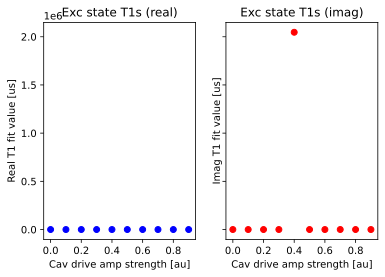

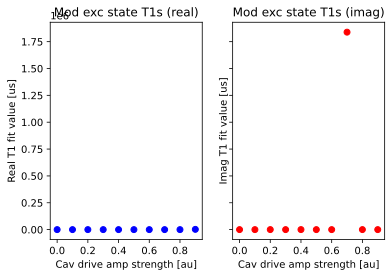

In [146]:
# Compare real and imaginary T1 components across all amps, for both exc and phase-corrected exc
# Note: this plot doesn't look useful because of how rapidly one of the curves decays, we remedy this in the next cell
# by eliminating the outlier
fig, ax = plt.subplots(1, 2, sharey='row')
ax[0].scatter(amps_v1, np.real(exc_T1s), color='blue')
ax[0].set_xlabel("Cav drive amp strength [au]")
ax[0].set_ylabel("Real T1 fit value [us]")
ax[0].set_title("Exc state T1s (real)")
    
ax[1].scatter(amps_v1, np.imag(exc_T1s), color='red')
ax[1].set_xlabel("Cav drive amp strength [au]")
ax[1].set_ylabel("Imag T1 fit value [us]")
ax[1].set_title("Exc state T1s (imag)")
    
plt.show()

fig, ax = plt.subplots(1, 2, sharey='row')
ax[0].scatter(amps_v1, np.real(mod_exc_T1s), color='blue')
ax[0].set_xlabel("Cav drive amp strength [au]")
ax[0].set_ylabel("Real T1 fit value [us]")
ax[0].set_title("Mod exc state T1s (real)")
    
ax[1].scatter(amps_v1, np.imag(mod_exc_T1s), color='red')
ax[1].set_xlabel("Cav drive amp strength [au]")
ax[1].set_ylabel("Imag T1 fit value [us]")
ax[1].set_title("Mod exc state T1s (imag)")
    
plt.show()

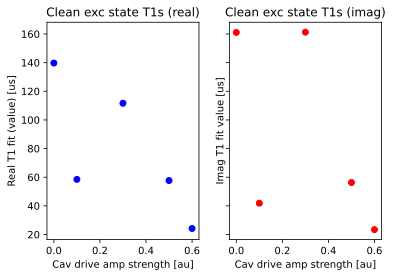

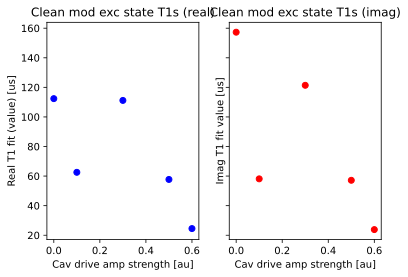

In [147]:
# Compare again but with outlying T1 values + their corresponding amps removed. Only keep exc/mod exc values for which
# neither real nor imaginary parts are extreme.
# Note: we do not expect any conclusive pattern from this, we suspect something is wrong with our methodology
# because the T1 value should not be falling this much across the amps.
fig, ax = plt.subplots(1, 2, sharey='row')
ax[0].scatter(clean_amps_v1, np.real(clean_exc_T1s), color='blue')
ax[0].set_xlabel("Cav drive amp strength [au]")
ax[0].set_ylabel("Real T1 fit (value) [us]")
ax[0].set_title("Clean exc state T1s (real)")
    
ax[1].scatter(clean_amps_v1, np.imag(clean_exc_T1s), color='red')
ax[1].set_xlabel("Cav drive amp strength [au]")
ax[1].set_ylabel("Imag T1 fit value [us]")
ax[1].set_title("Clean exc state T1s (imag)")
    
plt.show()

fig, ax = plt.subplots(1, 2, sharey='row')
ax[0].scatter(clean_amps_v1, np.real(clean_mod_exc_T1s), color='blue')
ax[0].set_xlabel("Cav drive amp strength [au]")
ax[0].set_ylabel("Real T1 fit (value) [us]")
ax[0].set_title("Clean mod exc state T1s (real)")
    
ax[1].scatter(clean_amps_v1, np.imag(clean_mod_exc_T1s), color='red')
ax[1].set_xlabel("Cav drive amp strength [au]")
ax[1].set_ylabel("Imag T1 fit value [us]")
ax[1].set_title("Clean mod exc state T1s (imag)")
    
plt.show()

In [148]:
# Print raw T1 fitted values
exc_T1s, mod_exc_T1s

([(139.7141190916488+161.090216858086j),
  (58.470923393082124+41.867607703310775j),
  (157.40500119326268+7.042904109186227j),
  (111.64740211341986+161.27939369377054j),
  (120.37441687996447+2046740.7220465415j),
  (57.662716314786806+56.27420372518022j),
  (24.196097199690083+23.397761117386437j),
  (21.748519127648198+343.0013441679976j),
  (11.889502699505433+173.5245070622735j),
  (10.020362217397015+69.11135843638326j)],
 [(112.36696446500235+157.29262476710971j),
  (62.54789512105251+58.13118889907761j),
  (153.89465062969413+341.5108585529985j),
  (111.15521344459283+121.38842723323452j),
  (116.5418914465443+359.24511835647627j),
  (57.723688766587905+57.15860158878452j),
  (24.511482146404923+23.819206419163763j),
  (27.32598363185063+1838435.3840125054j),
  (16.131040394141976+273.32562092715165j),
  (2481.1237596801056+63.269963472896414j)])

In [149]:
# Print only T1 values without outliers
clean_exc_T1s, clean_mod_exc_T1s

([(139.7141190916488+161.090216858086j),
  (58.470923393082124+41.867607703310775j),
  (111.64740211341986+161.27939369377054j),
  (57.662716314786806+56.27420372518022j),
  (24.196097199690083+23.397761117386437j)],
 [(112.36696446500235+157.29262476710971j),
  (62.54789512105251+58.13118889907761j),
  (111.15521344459283+121.38842723323452j),
  (57.723688766587905+57.15860158878452j),
  (24.511482146404923+23.819206419163763j)])

In [ ]:
# We are unsure how to resolve this behavior. Real and imaginary components of decay seem to often occur on very
# diff timescales, leading to some very different fitting. Are we considering the "modified excited states" correctly
# by trying to match up the final phase of the excited data with that of the ground data?